# Aasq GAMP Figures

**Copyright (c) 2016, Christian Schou Oxvig, Thomas Arildsen, and Torben Larsen**  
**All rights reserved.**

This notebook shows figures detailing noiseless emperical phase transition curves for various Generalized Approximate Message Passing (GAMP) algorithms. The figures are based on the dataset "Generalized Approximate Message Passing Practical 2D Phase Transition Simulations Dataset" by Christian Schou Oxvig, Thomas Arildsen, and Torben Larsen licensed under CC BY 4.0 (http://creativecommons.org/licenses/by/4.0/). The full dataset along with its license conditions is available at https://dx.doi.org/10.5281/zenodo.165051.

Furthermore, parts of the results from "Replication of certain details from J. P. Vila and P. Schniter: "Expectation-Maximization Bernoulli-Gaussian Approximate Message Passing"" by Thomas Arildsen licensed under the BSD 2-Clause license are used in Figure 1. The full deposition along with its license conditions is available at https://doi.org/10.5281/zenodo.160700.

In [1]:
%matplotlib inline

from __future__ import division
import itertools

import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tables as tb

import magni

mpl.style.use('ggplot')
fig_size = mpl.rcParams['figure.figsize']
cb5 = magni.utils.plotting._ColourCollection(
    {'RdYlBu': ((215, 25, 28), (253, 174, 97), (255, 255, 191), (171, 217, 233), (44, 123, 182))})
color_cycle = cycler.cycler('color', cb5['RdYlBu'])
style_cycle_errorbar = cycler.cycler(  # For matplotlib 1.5.3, see https://github.com/matplotlib/matplotlib/issues/7074
    'ls', itertools.chain(*[['', '', ls] for ls in magni.utils.plotting.linestyles[:2]]))
magni.utils.plotting.setup_matplotlib({'figure': {'dpi': 800, 'figsize': [fs * 2 for fs in fig_size]},
                                       'axes': {'prop_cycle': color_cycle * style_cycle_errorbar},
                                       'grid': {'alpha': 0.25}})

/usr/local/continuum/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data paths

In [2]:
# Paths to "gamp_practical_2d_phase_transitions_ID_[0-4]_of_5.hdf5" from https://dx.doi.org/10.5281/zenodo.165051.
# File                                                MD5SUM                            SHA256SUM
# gamp_practical_2d_phase_transitions_ID_0_of_5.hdf5  a9b7cc5c64ff1f900f8fa0ab607f0543  f74fa5f976f00d5d3a32c0ac98b5b37cd11bfd55248b88fbc18ac98fef518640
# gamp_practical_2d_phase_transitions_ID_1_of_5.hdf5  333cce779423e884bf9a0684321bfcf7  118182086822abc1ec22980fc22d8fd2c622de0b19fe29e4d0e6095e7971a346 
# gamp_practical_2d_phase_transitions_ID_2_of_5.hdf5  4bd9dad316839435c043f7d0d59c4f4d  365b3118f10da83d7f173301c96cbf5bca47835e48a4e0da144818622ca1866f
# gamp_practical_2d_phase_transitions_ID_3_of_5.hdf5  6ad91ff617f55b1c87d75a75c1b9c9f7  b0d57022f9c4e72a2ac0a441b3d120df06791cc33d35d0bcfb2129334496720f
# gamp_practical_2d_phase_transitions_ID_4_of_5.hdf5  6d89403eaa297eaff5f287a6ff3f4d49  391f8096bec5915c93ca6167c6a41da28ebe01fbb61bb8df151c2430f23037d5
hdf5_database_paths = ['gamp_practical_2d_phase_transitions_ID_0_of_5.hdf5',
                       'gamp_practical_2d_phase_transitions_ID_1_of_5.hdf5',
                       'gamp_practical_2d_phase_transitions_ID_2_of_5.hdf5',
                       'gamp_practical_2d_phase_transitions_ID_3_of_5.hdf5',
                       'gamp_practical_2d_phase_transitions_ID_4_of_5.hdf5',]

# Path to "vila2011_results_old_not_unif.mat" from https://doi.org/10.1109/ACSSC.2011.6190117
# MD5SUM: 2cf3713c31ddb69de84f3fc5eb3fe94b
# SHA256SUM: a7e6361a31099fa9abb7cb669f97c9ac1a3dddcbba23a8fafb89f95ffd19af6d
vila2011_reference_path = 'vila2011_results_old_not_unif.mat'


algorithm_names = {'AMPresidual_genie': 'DMM AMP R',
                   'AMPmedian_genie': 'DMM AMP M',
                   'GAMPFull_genie': 'GAMP using $|\mathbf{A}|^{\\circ 2}$ (genie)',
                   'GAMPFull_vila': 'GAMP using $|\mathbf{A}|^{\\circ 2}$ (EM)',
                   'GAMPSAKrzakala1m_genie': 'GAMP using Krzakalas SA with variance $1/m$ (genie)',
                   'GAMPSAKrzakala1m_vila': 'GAMP using Krzakalas SA with variance $1/m$ (EM)',
                   'GAMPSAKrzakala1n_genie': 'GAMP using Krzakalas SA with variance $1/n$ (genie)',
                   'GAMPSAKrzakala1n_vila': 'GAMP using Krzakalas SA with variance $1/n$ (EM)',
                   'GAMPSARangan_genie': 'GAMP using Rangans SA (genie)',
                   'GAMPSARangan_vila': 'GAMP using Rangans SA (EM)'}

# Load data

In [3]:
skips = ['annotations', 'chases', 'fileset', 'gamp_pt_tools', 'parameter_values']

pt_curves = {}
pt_dists = {}
pt_times = {}
pt_norms = {}
pt_mses = {}
pt_percentiles = {}

for hdf5_database_path in hdf5_database_paths:
    with tb.File(hdf5_database_path, mode='r') as h5_file:
        for group in h5_file.walk_groups('/'):
            label = group._v_name
            if any([skip in label for skip in skips]) or group is h5_file.root:
                continue

            pt_dists[label] = h5_file.get_node('/' + '/'.join([label, 'dist'])).read()
            pt_times[label] = h5_file.get_node('/' + '/'.join([label, 'time'])).read()
            pt_norms[label] = h5_file.get_node('/' + '/'.join([label, 'norm'])).read()
            pt_mses[label] = h5_file.get_node('/' + '/'.join([label, 'mse'])).read()
            pt_percentiles[label] = h5_file.get_node('/' + '/'.join([label, 'phase_transition_percentiles'])).read()
            pt_curves[label] = magni.cs.phase_transition.io.load_phase_transition(hdf5_database_path, label=label)

# Figure 1

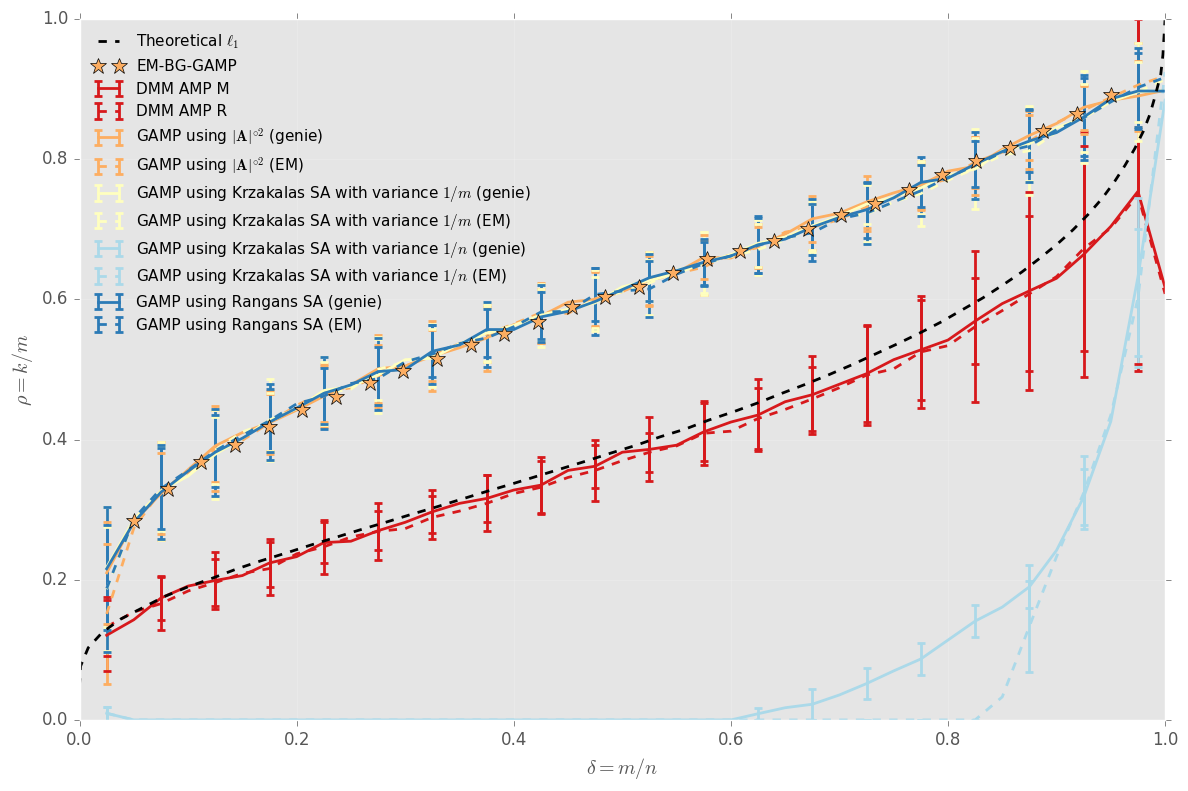

In [4]:
fig_1_pt_curves = [
    {'delta': pt[0],
     'rho': pt[1],
     'yerr': np.vstack([pt_percentiles[curve_label][0, :], pt_percentiles[curve_label][3, :]]),  # 90/10 errorbars
     'label': algorithm_names['_'.join([curve_label.split('_')[k] for k in [0, -1]])]}
    for curve_label, pt in sorted(pt_curves.items())
    if all([select_criterion in curve_label
            for select_criterion in ['32', 'USE']])]

vila_2011_reference_data = scipy.io.loadmat(vila2011_reference_path)
vila_2011_reference_pt_curves = [
    {'delta': vila_2011_reference_data['delta_values'].ravel(),
     'rho': vila_2011_reference_data['transition_rho_values_EMBGAMP'].ravel(),
     'label': 'EM-BG-GAMP',
     'style': {'color': (0.99, 0.68, 0.38), 'marker': '*', 'linestyle':'None', 'ms': 12}}
]

magni.cs.phase_transition.plotting.plot_phase_transitions(fig_1_pt_curves, plot_l1=True, errorevery=2, reference_curves=vila_2011_reference_pt_curves)

plt.gcf().gca().axes.lines[-2].set_linestyle('--')
plt.gcf().gca().legend(loc='upper left')
plt.gcf().gca().get_legend().get_frame().set_alpha(0)

plt.savefig('fig1.pdf')

_ = ! pdfcrop 'fig1.pdf'
plt.show()

# Figure 2

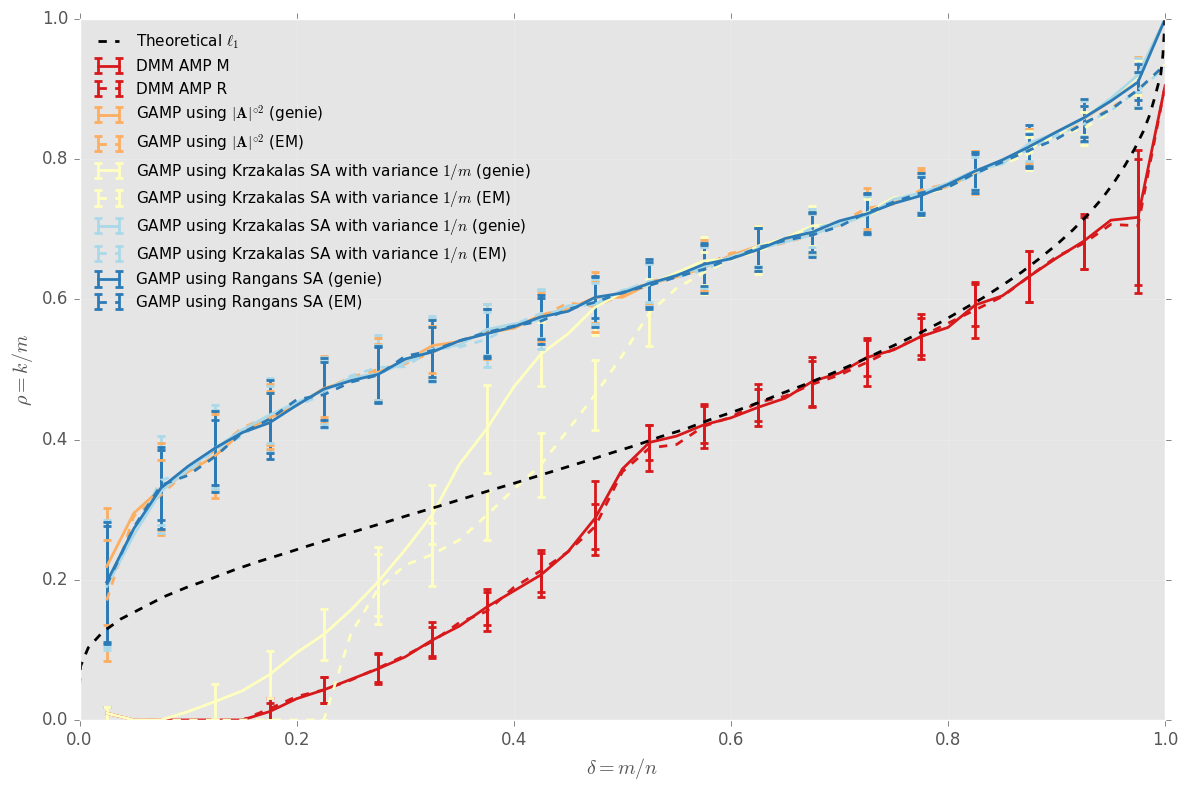

In [5]:
fig_2_pt_curves = [
    {'delta': pt[0],
     'rho': pt[1],
     'yerr': np.vstack([pt_percentiles[curve_label][0, :], pt_percentiles[curve_label][3, :]]),  # 90/10 errorbars
     'label': algorithm_names['_'.join([curve_label.split('_')[k] for k in [0, -1]])]}
    for curve_label, pt in sorted(pt_curves.items())
    if all([select_criterion in curve_label
            for select_criterion in ['32', 'RandomDCT2D']])]

magni.cs.phase_transition.plotting.plot_phase_transitions(fig_2_pt_curves, plot_l1=True, errorevery=2)

plt.gcf().gca().axes.lines[-1].set_linestyle('--')
plt.gcf().gca().legend(loc='upper left')
plt.gcf().gca().get_legend().get_frame().set_alpha(0)
plt.savefig('fig2.pdf')

_ = ! pdfcrop 'fig2.pdf'
plt.show()

# Figure 3

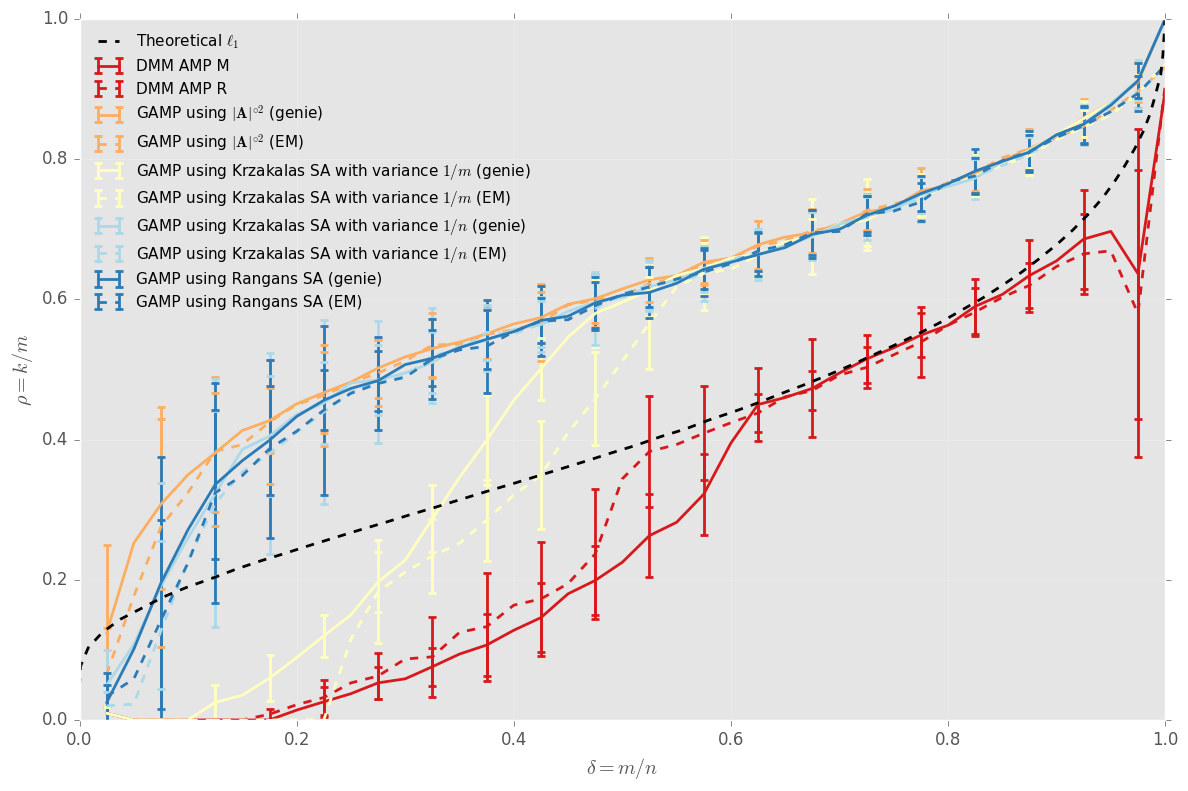

In [6]:
fig_3_pt_curves = [
    {'delta': pt[0],
     'rho': pt[1],
     'yerr': np.vstack([pt_percentiles[curve_label][0, :], pt_percentiles[curve_label][3, :]]),  # 90/10 errorbars
     'label': algorithm_names['_'.join([curve_label.split('_')[k] for k in [0, -1]])]}
    for curve_label, pt in sorted(pt_curves.items())
    if all([select_criterion in curve_label
            for select_criterion in ['32', 'DFTDWT']])]

magni.cs.phase_transition.plotting.plot_phase_transitions(fig_3_pt_curves, plot_l1=True, errorevery=2)

plt.gcf().gca().axes.lines[-1].set_linestyle('--')
plt.gcf().gca().legend(loc='upper left')
plt.gcf().gca().get_legend().get_frame().set_alpha(0)
plt.savefig('fig3.pdf')

_ = ! pdfcrop 'fig3.pdf'
plt.show()

# Extra material

### SEM and MRI for problem sizes $64^2$ and $128^2$

SEM for a problem size of 64^2


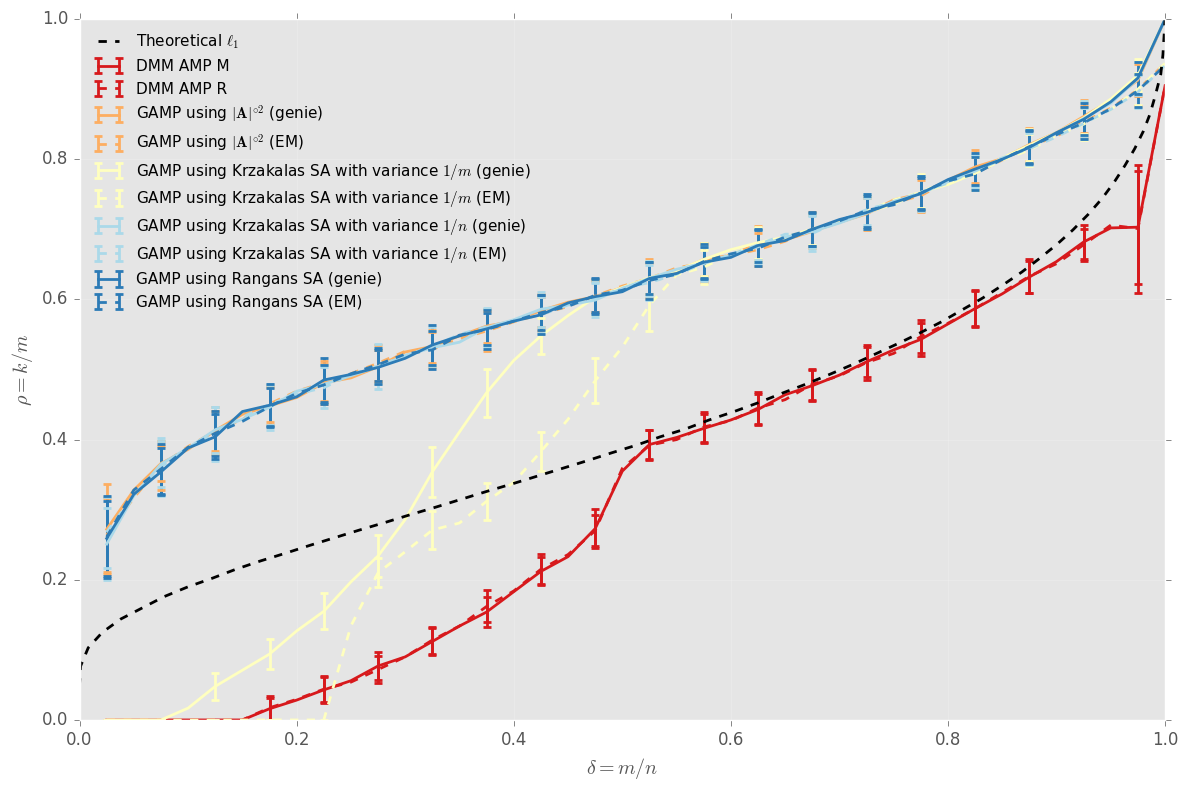

SEM for a problem size of 128^2


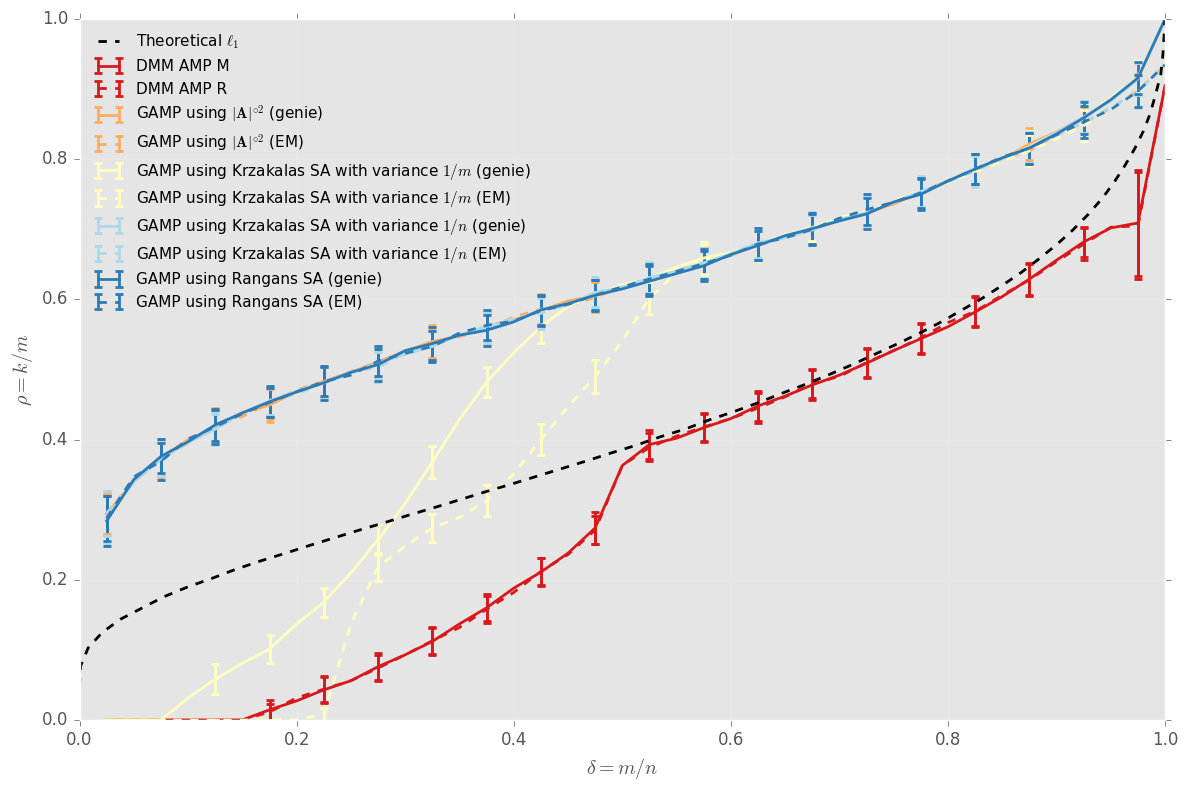

MRI for a problem size of 64^2


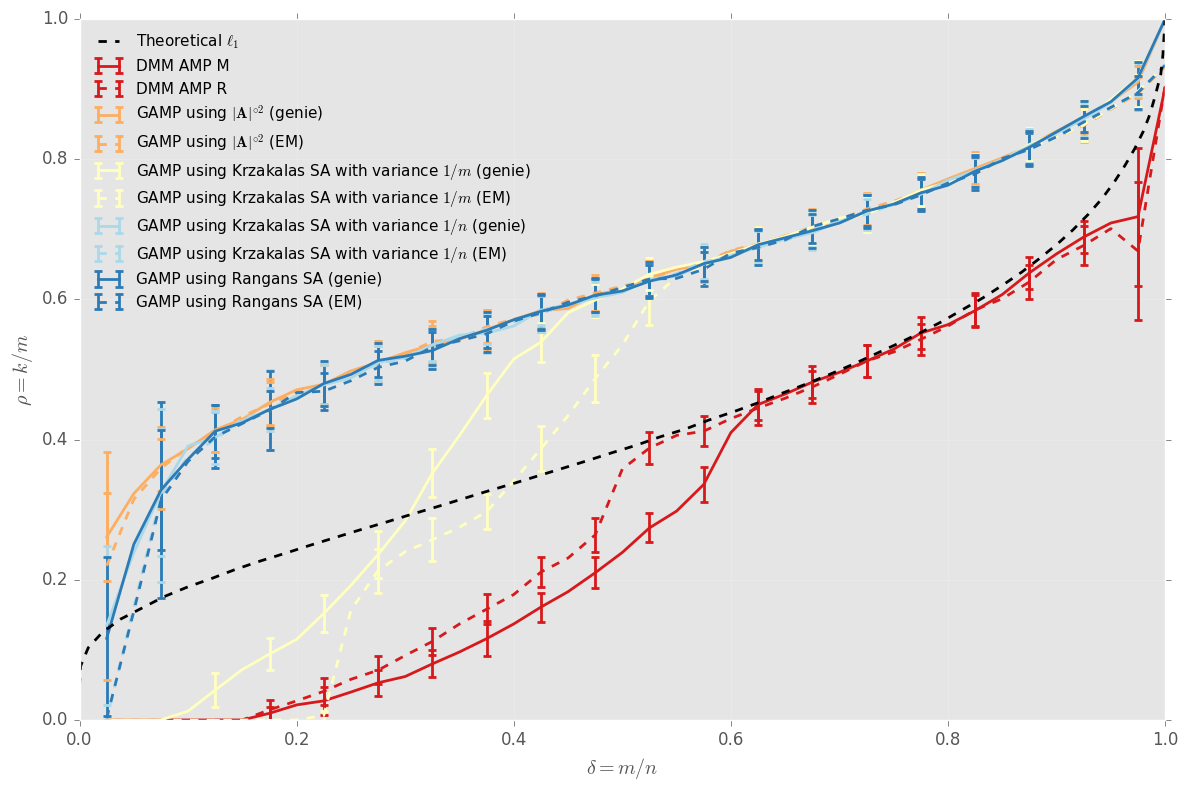

MRI for a problem size of 128^2


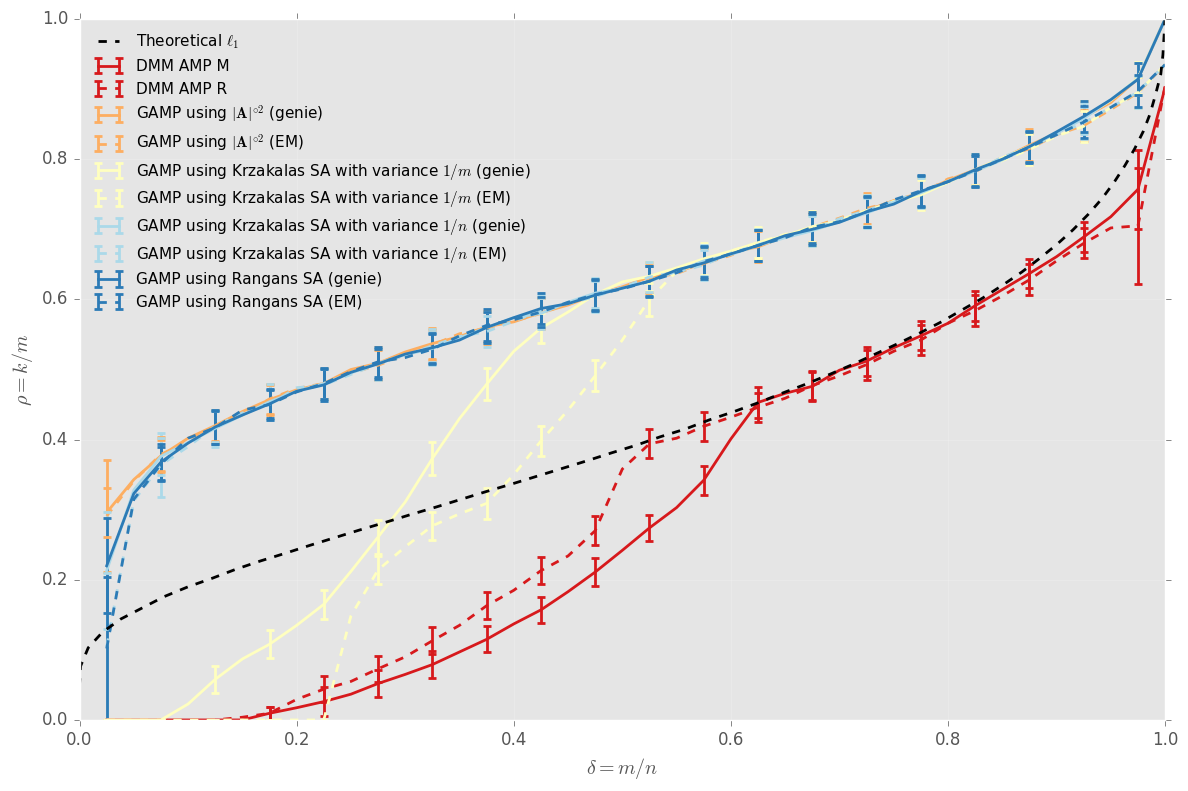

In [7]:
ensemble_names = {'RandomDCT2D': 'SEM', 'DFTDWT': 'MRI'}

for matrix_ensemble in ['RandomDCT2D', 'DFTDWT']:
    for problem_size in ['64', '128']:
        print('{} for a problem size of {}^2'.format(ensemble_names[matrix_ensemble], problem_size))
        
        disp_pt_curves = [
            {'delta': pt[0],
             'rho': pt[1],
             'yerr': np.vstack([pt_percentiles[curve_label][0, :], pt_percentiles[curve_label][3, :]]),  # 90/10 errorbars
             'label': algorithm_names['_'.join([curve_label.split('_')[k] for k in [0, -1]])]}
            for curve_label, pt in sorted(pt_curves.items())
            if all([select_criterion in curve_label
                    for select_criterion in [problem_size, matrix_ensemble]])]

        magni.cs.phase_transition.plotting.plot_phase_transitions(disp_pt_curves, plot_l1=True, errorevery=2)
        plt.gcf().gca().axes.lines[-1].set_linestyle('--')
        plt.gcf().gca().legend(loc='upper left')
        plt.gcf().gca().get_legend().get_frame().set_alpha(0)
        
        plt.show()

### The MRI case for problem sizes $32^2$, $64^2$, and $128^2$ in a single figure

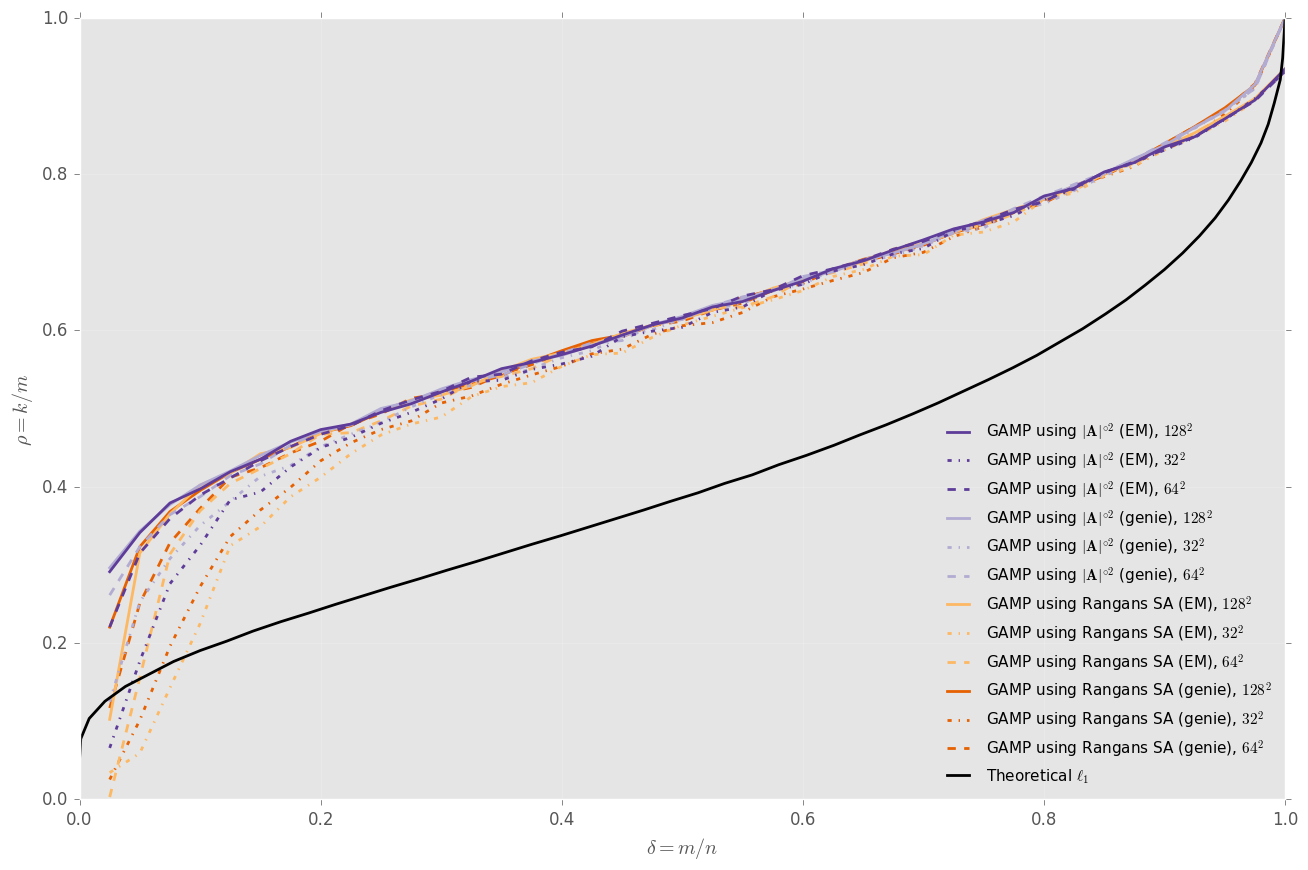

In [8]:
cb4 = magni.utils.plotting.colour_collections['cb4']
color_cycle = cycler.cycler('color', cb4['PuOr'])
style_cycle_errorbar = cycler.cycler('ls', magni.utils.plotting.linestyles[:3])
magni.utils.plotting.setup_matplotlib({'figure': {'dpi': 800, 'figsize': [fs * 2.2 for fs in fig_size]},
                                        'axes': {'prop_cycle': color_cycle * style_cycle_errorbar}})

disp_pt_curves = [
    {'delta': pt[0],
     'rho': pt[1],
     'label': algorithm_names['_'.join([curve_label.split('_')[k] for k in [0, -1]])] + ', ${}$'.format(curve_label.split('_')[5].replace('p','^'))}
    for curve_label, pt in sorted(pt_curves.items())
    if 'DFTDWT' in curve_label and ('Full' in curve_label or 'Rangan' in curve_label)]
disp_pt_curves = sorted(disp_pt_curves, key=lambda curve: curve['label'][:-7])[::-1]

magni.cs.phase_transition.plotting.plot_phase_transitions(
    disp_pt_curves, plot_l1=True, errorevery=2, legend_loc='lower right')
plt.gcf().gca().get_legend().get_frame().set_alpha(0)

# Metadata about how this notebook was run

In [9]:
magni.reproducibility.data.get_datetime()

{'pretty_utc': 'Mon Nov  7 09:58:23 2016',
 'status': 'Succeeded',
 'today': 'datetime.datetime(2016, 11, 7, 10, 58, 23, 816576)',
 'utcnow': 'datetime.datetime(2016, 11, 7, 9, 58, 23, 816606)'}

In [10]:
magni.reproducibility.data.get_git_revision()

{'branch': 'v1.6.0',
 'remote': 'origin\tgit@github.com:SIP-AAU/Magni.git (fetch)\norigin\tgit@github.com:SIP-AAU/Magni.git (push)',
 'status': 'Succeeded',
 'tag': 'v1.6.0'}

In [11]:
magni.reproducibility.data.get_platform_info()

{'libc': '["glibc", "2.2.5"]',
 'linux': '["", "", ""]',
 'mac_os': '["", ["", "", ""], ""]',
 'machine': '"x86_64"',
 'node': '"CSOLAP"',
 'processor': '""',
 'python': '"2.7.12"',
 'release': '"4.4.30-1-lts"',
 'status': 'All OK',
 'system': '"Linux"',
 'version': '"#1 SMP Tue Nov 1 22:09:20 CET 2016"',
 'win32': '["", "", "", ""]'}

In [12]:
magni.reproducibility.data.get_conda_info()

{'channels': '{"https://conda.anaconda.org/chroxvi/linux-64": ["chroxvi", 0], "https://conda.anaconda.org/chroxvi/noarch": ["chroxvi", 0], "https://repo.continuum.io/pkgs/free/linux-64": ["defaults", 1], "https://repo.continuum.io/pkgs/free/noarch": ["defaults", 1], "https://repo.continuum.io/pkgs/pro/linux-64": ["defaults", 1], "https://repo.continuum.io/pkgs/pro/noarch": ["defaults", 1]}',
 'conda_is_private': 'false',
 'conda_version': '4.2.12',
 'config_file': '"/home/chroxvi/.condarc"',
 'default_prefix': '/usr/local/continuum/anaconda',
 'env_export': '{"name": "root", "channels": ["https://conda.anaconda.org/chroxvi", "defaults"], "dependencies": ["_license=1.1=py27_1", "_nb_ext_conf=0.3.0=py27_0", "abstract-rendering=0.5.1=np111py27_0", "accelerate_cudalib=2.0=0", "alabaster=0.7.9=py27_0", "anaconda=4.2.0=np111py27_0", "anaconda-clean=1.0.0=py27_0", "anaconda-client=1.5.3=py27_0", "anaconda-navigator=1.3.1=py27_0", "argcomplete=1.0.0=py27_1", "astroid=1.4.7=py27_0", "astropy=1.